In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [2]:
df = pd.read_csv("gs://{Bucket Name}/blog/blog_data.csv")
df["clientid"] = df['clientid'].apply(lambda x: x.lstrip("'"))
df=df.head(10000)

In [5]:
user_le = LabelEncoder()
df['clientid'] = user_le.fit_transform(df['clientid'])

item_le = LabelEncoder()
df['blog'] = item_le.fit_transform(df['blog'])

In [6]:
n_users = df.clientid.unique().shape[0]
n_items = df.blog.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1], row[2]] = row[3]
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.23%


In [9]:
## Utility
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=int(np.ceil(len(ratings[user, :].nonzero()[0])*0.3)), 
                                        replace=True)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test


def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [10]:
train, test = train_test_split(ratings)

In [11]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')

In [12]:
item_prediction = predict_fast_simple(test, item_similarity, kind='item')
user_prediction = predict_fast_simple(test, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 2.405896551127378
Item-based CF MSE: 1.2790888211100133


In [13]:
pred = predict_topk(test, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(test, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 2.388906184913773
Top-k Item-based CF MSE: 1.2324727239719033


In [16]:
k_array = [5, 15, 30, 50]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []


for k in tqdm(k_array):
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    item_train_mse += [get_mse(item_pred, train)]
    
    user_pred = predict_topk(test, user_similarity, kind='user', k=k)
    item_pred = predict_topk(test, item_similarity, kind='item', k=k)
    
    user_test_mse += [get_mse(user_pred, test)]
    item_test_mse += [get_mse(item_pred, test)]  

100%|██████████| 4/4 [17:40<00:00, 265.18s/it]


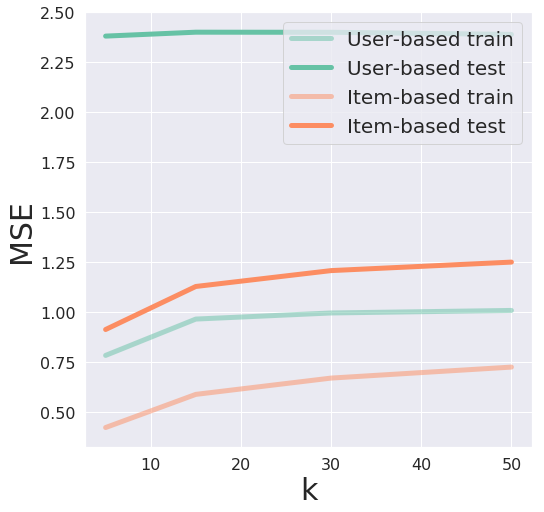

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [18]:
user_pred = predict_nobias(test, user_similarity, kind='user')
print('Bias-subtracted User-based CF MSE: ' + str(get_mse(user_pred, test)))

item_pred = predict_nobias(test, item_similarity, kind='item')
print('Bias-subtracted Item-based CF MSE: ' + str(get_mse(item_pred, test)))

Bias-subtracted User-based CF MSE: 2.3975079251588824
Bias-subtracted Item-based CF MSE: 1.2754437545747017


In [19]:
k_array = [5, 15, 30, 50]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in tqdm(k_array):
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    item_train_mse += [get_mse(item_pred, train)]
    
    user_pred = predict_topk(test, user_similarity, kind='user', k=k)
    item_pred = predict_topk(test, item_similarity, kind='item', k=k)
    
    user_test_mse += [get_mse(user_pred, test)]
    item_test_mse += [get_mse(item_pred, test)]   

100%|██████████| 4/4 [18:16<00:00, 274.10s/it]


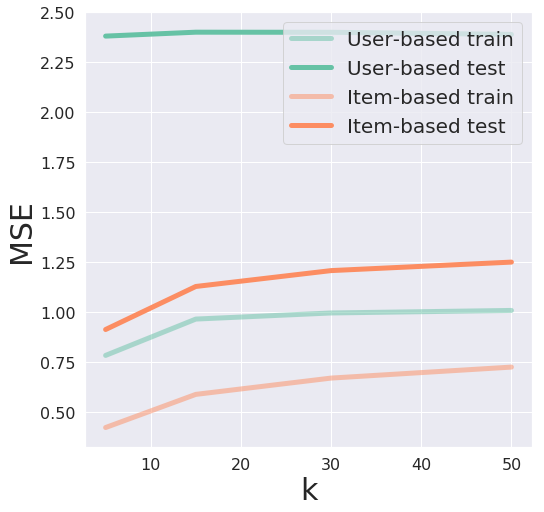

In [20]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [21]:
user_test_mse

[2.3809497744073496, 2.400558436028061, 2.4000566571870694, 2.3894151228865654]

In [22]:
user_train_mse

[0.7837421941174302, 0.9654874826779466, 0.9960127146836966, 1.008694314402933]

In [24]:
np.mean(user_train_mse), np.mean(user_test_mse)

(0.9384841764705016, 2.3927449976272612)